In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import seaborn as sns
import ipywidgets as widgets

# Import data

## Trading 

In [2]:
trading_results_df = pd.read_parquet('../../Results/trading_results/results.parquet')
trading_returns_df = pd.read_parquet('../../Results/trading_results/returns.parquet')

## BBG data

In [3]:
bbg_df = pd.read_stata('../../data/calendars/bbg_96_18_econrelease.dta')
bbg_df

,Date,Time,Country,Event,Ticker,Period,Relevance,Survey,Actual,Prior,Revised,Units
0,1996-10-31,08:30,US,Personal Income,PITLCHNG Index,Sep,85.71430,0.006,0.006,0.006,NaN,
1,1996-10-31,08:30,US,US Personal Outlays SA,PIDSSO Index,Sep,0.00000,0.003,0.001,0.006,NaN,
2,1996-11-01,10:00,US,ISM Manufacturing,NAPMPMI Index,Oct,96.03170,50.900,50.200,51.700,NaN,
3,1996-11-01,10:00,US,Factory Orders,TMNOCHNG Index,Sep,87.30160,0.027,0.027,-0.019,NaN,
4,1996-11-04,10:00,US,Construction Spending,VNCCTOT Index,Sep,0.00000,-0.100,-1.100,0.900,NaN,$
...,...,...,...,...,...,...,...,...,...,...,...,...
24681,2018-12-28,10:00,US,Pending Home Sales NSA YoY,USPHTYOY Index,Nov,28.34650,NaN,NaN,NaN,NaN,
24682,2018-12-28,08:30,US,Advance Goods Trade Balance,USTGTTCB Index,Nov,7.08661,NaN,NaN,NaN,NaN,
24683,2018-12-28,08:30,US,Retail Inventories MoM,RSRSTMOM Index,Nov,3.93701,NaN,NaN,NaN,NaN,
24684,2018-12-31,09:45,US,Chicago Purchasing Manager,CHPMINDX Index,Dec,81.88980,NaN,NaN,NaN,NaN,


# Analysis

In [4]:
## Returns around FOMC announcements
trading_strategies_models = [('Benchmark', 'Market'), ('Lasso_PCA_select', 'MS Strategy 0.5')]

## Event study

In [12]:
## Set up FOMC Event dataframe
# Pick events
bbg_events_df = bbg_df.loc[bbg_df['Event'].str.contains('ISM Manufacturing', regex=True)].copy()
bbg_events_df = bbg_events_df.loc[(bbg_events_df['Time'] < '16:00') & (bbg_events_df['Time'] > '09:30')]
# bbg_events_df = bbg_df.query('Time == "10:00"').copy()

# Clean up
bbg_events_df['datetime'] = pd.to_datetime(bbg_events_df['Date'].astype(str) + ' ' + bbg_events_df['Time'].astype(str), errors = 'coerce')
bbg_events_df['datetime_rounded'] = pd.to_datetime(bbg_events_df['datetime']).dt.ceil('15min')
bbg_events_df['is_intraday'] = (bbg_events_df['datetime'].dt.time < dt.time(16,0)) & (bbg_events_df['datetime'].dt.time > dt.time(9,30))
# bbg_events_df = bbg_events_df.query('is_intraday == True').drop_duplicates(['datetime'])

# View
bbg_events_df.sort_values(by = 'Time')

,Date,Time,Country,Event,Ticker,Period,Relevance,Survey,Actual,Prior,Revised,Units,datetime,datetime_rounded,is_intraday
2,1996-11-01,10:00,US,ISM Manufacturing,NAPMPMI Index,Oct,96.0317,50.9,50.2,51.7,NaN,,1996-11-01 10:00:00,1996-11-01 10:00:00,True
11942,2010-11-01,10:00,US,ISM Manufacturing,NAPMPMI Index,Oct,96.0317,54.0,56.9,54.4,56.3,,2010-11-01 10:00:00,2010-11-01 10:00:00,True
12061,2010-12-01,10:00,US,ISM Manufacturing,NAPMPMI Index,Nov,96.0317,56.5,56.6,56.9,57.7,,2010-12-01 10:00:00,2010-12-01 10:00:00,True
12173,2011-01-03,10:00,US,ISM Manufacturing,NAPMPMI Index,Dec,96.0317,57.0,57.0,56.6,57.6,,2011-01-03 10:00:00,2011-01-03 10:00:00,True
12279,2011-02-01,10:00,US,ISM Manufacturing,NAPMPMI Index,Jan,96.0317,58.0,60.8,57.0,57.5,,2011-02-01 10:00:00,2011-02-01 10:00:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5028,2004-10-01,10:00,US,ISM Manufacturing,NAPMPMI Index,Sep,96.0317,58.4,58.5,59.0,58.5,,2004-10-01 10:00:00,2004-10-01 10:00:00,True
5102,2004-11-01,10:00,US,ISM Manufacturing,NAPMPMI Index,Oct,96.0317,58.5,56.8,58.5,57.4,,2004-11-01 10:00:00,2004-11-01 10:00:00,True
5184,2004-12-01,10:00,US,ISM Manufacturing,NAPMPMI Index,Nov,96.0317,57.0,57.8,56.8,56.3,,2004-12-01 10:00:00,2004-12-01 10:00:00,True
4135,2003-10-01,10:00,US,ISM Manufacturing,NAPMPMI Index,Sep,96.0317,54.5,53.7,54.7,53.2,,2003-10-01 10:00:00,2003-10-01 10:00:00,True


In [13]:
def plot_helper(fig, ax, trading_strategy_model):

    # Label
    series_label = " - ".join(trading_strategy_model)

    # Trading returns
    tr_ret_df = (
        trading_returns_df[trading_strategy_model]
        .rename(series_label)
        .to_frame()
        .copy()
        .assign(
            bbg_dates=pd.to_datetime(trading_returns_df.index.date).isin(
                bbg_events_df["datetime"].dt.date
            )
        )
    )
    tr_ret_df["date"] = tr_ret_df.index.date
    tr_ret_df["time"] = tr_ret_df.index.time
    tr_ret_df = tr_ret_df.loc[tr_ret_df.index.time != dt.time(9, 30)]
    bbg_dates = tr_ret_df.query("bbg_dates == True")["date"].unique()
    tr_ret_pivot_df = tr_ret_df.pivot(index="time", columns="date", values=[series_label])

    ## Plot
    # Figure
    fig, ax = plt.subplots(figsize=(20, 6), ncols=1)

    # Returns
    sns.pointplot(x = 'time', y = series_label, hue = 'bbg_dates', alpha = 0.8, data = tr_ret_df)
    ax.set_title(f"Trading Strategy Returns\n{series_label}")
    ax.xaxis.set_major_locator(mtick.MultipleLocator(2))
    ax.legend()

In [14]:
fig = plt.figure(figsize=(18, 5))
axes = fig.add_subplot(111)
plt.close()
# hfig = display(fig, display_id=True)

def draw():
    #fig.clf()
    # axes.plot(values, [v*v for v in values])
    # axes.grid(False)
    # axes.set_ylabel('Return (%)')
    # fig.canvas.draw();
    # hfig.update(fig);
    # time.sleep(1)
    pass

def update(strategy = 'Benchmark', model = 'Market'):
    
    # Vars
    trading_strategy_model = (strategy, model)
    
    # Update plot
    axes.cla()
    plot_helper(fig, axes, trading_strategy_model)
    # fig.canvas.draw();
    # hfig.update(fig);
    plt.show()
    

# update('Benchmark', 'Market')

strategy_selector = widgets.Dropdown(
    options=pd.unique(trading_returns_df.columns.get_level_values(0)),
    value='Benchmark',
    description='Strategy:',
)
model_selector = widgets.Dropdown(
    options=pd.unique(trading_returns_df.columns.get_level_values(1)),
    value='Market',
    description='Model:',
)
widgets.interact(update, strategy =strategy_selector, model = model_selector);

interactive(children=(Dropdown(description='Strategy:', options=('Benchmark', 'LR', 'LR_PCA_select', 'LR_Lasso…

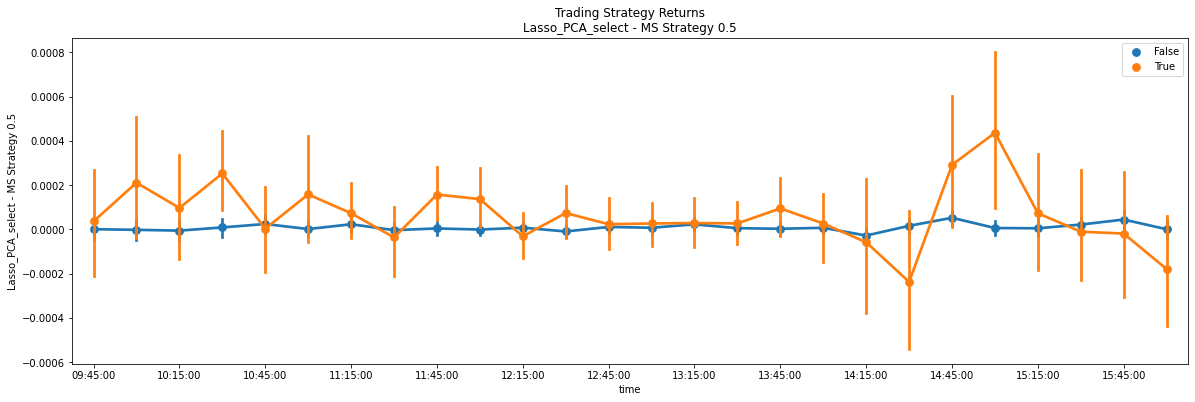

In [31]:
# Define strategy+model
trading_strategy_model = trading_strategies_models[1]
series_label = " - ".join(trading_strategy_model)

# Trading returns
tr_ret_df = (
    trading_returns_df[trading_strategy_model]
    .rename(series_label)
    .to_frame()
    .copy()
    .assign(
        bbg_dates=pd.to_datetime(trading_returns_df.index.date).isin(
            bbg_events_df["datetime"].dt.date
        )
    )
)
tr_ret_df["date"] = tr_ret_df.index.date
tr_ret_df["time"] = tr_ret_df.index.time
tr_ret_df = tr_ret_df.loc[tr_ret_df.index.time != dt.time(9, 30)]
bbg_dates = tr_ret_df.query("bbg_dates == True")["date"].unique()
tr_ret_pivot_df = tr_ret_df.pivot(index="time", columns="date", values=[series_label])

## Plot
# Figure
fig, ax = plt.subplots(figsize=(20, 6), ncols=1)

# Returns
sns.pointplot(x = 'time', y = series_label, hue = 'bbg_dates', alpha = 0.8, data = tr_ret_df)
ax.set_title(f"Trading Strategy Returns\n{series_label}")
ax.xaxis.set_major_locator(mtick.MultipleLocator(2))
ax.legend()